# Q1. Housing Price Prediction

Dataset Description: The data pertains to the houses found in each California district and some summary statistics about them based on the 1990 census data. It contains one instance per district block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). 

The goal of this task is to design a regression model to predict the median house value conditioned upon a set of input attributes corresponding to a particular California district block. 

The attributes in the dataset are as follows; their names are self-explanatory: 
* longitude (continuous): One of the coordinates that are used to identify the California district block 
* latitude (continuous): One of the coordinates that are used to identify the California district block 
* housing_median_age (continuous): Average age of the house in California district block 
* total_rooms (continuous): Total number of rooms of all the houses in the California district block 
* total_bedrooms (continuous): Total number of bedrooms of all the houses in the California district block 
* population (continuous): Number of people residing in the district block 
* households (continuous): Number of families in the district block 
* median_income (continuous): Median income for households in the district block of houses (measured in tens of thousands of US Dollars)  
* ocean_proximity (categorical): Location of the house. Is it inland, near the bay, near the ocean, etc.  
* median_house_value.(continuous): Median house value within a district block (measured in US Dollars)

Our target variable will be median_house_value.  Use the rest of the fields mentioned above to predict the median_house_value. 

## Import Libraries
Import all necessary libraries

In [1]:
# ! pip install numpy matplotlib scikit-learn pandas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
import warnings
warnings.filterwarnings(action='once')

### b. Data Loading / Preprocessing

#### i. Loading

1. Load the California housing dataset using `pandas.read_csv()` function and store it in the variable (i.e., a pandas dataframe) named `df’.

2. The resulting data frame should have the shape (20942, 10) indicating that there are 20942 rows and 10 columns.

In [4]:
df = pd.read_csv('housingmod.csv')
df.shape

(20942, 10)

3. Find the missing values in the data frame. If any (i.e., even if one column in each instance / row has a missing value), drop the row using `pandas.DataFrame.dropna()` function. The resulting data frame should have the shape (20735, 10) indicating that there are 20735 rows and 10 columns.

In [5]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [6]:
df = df.dropna()
print(df.shape)
print(df.isna().sum())

(20735, 10)
longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64


4. Now plot a box plot for median house values to check for extreme values using df.boxplot() function 

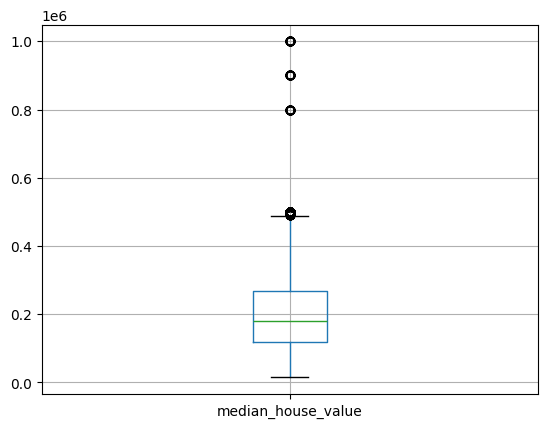

In [7]:
df.boxplot('median_house_value')
plt.show()

5.  Now filter the dataframe and remove all the values that are above 1.5iqr.
You can find the iqr by subtracting the 75th and 25th quantile using the quantile function in pandas.
You can then find the upper and lower limit by adding and subtracting 1.5*iqr to the 75th quantile and 25th quantile repectively

In [8]:
sf_quantile = df['median_house_value'].quantile(0.75)
tf_quantile = df['median_house_value'].quantile(0.25)
iqr = sf_quantile - tf_quantile
upper_bound = sf_quantile + 1.5 * iqr
lower_bound = tf_quantile - 1.5 * iqr
df = df[(df['median_house_value'] < upper_bound) & (df['median_house_value'] > lower_bound)]

6. You should see that the new shape of the dataframe is (19557,10)

In [9]:
df.shape

(19557, 10)

7. Create a data frame `corr_df` by dropping the columns latitude, longitude, and ocean_proximity using the `pandas.DataFrame.drop()` function. Use the Pearson correlation to find the correlation of each remaining feature in the `corr_df` with the target variable `median_house_value` using the function `pandas.DataFrame.corrwith()`. 

In [10]:
corr_df = df.drop(['latitude', 'longitude', 'ocean_proximity'], axis=1)
# corr_df.corrwith(df['median_house_value'])
corr_df.corrwith(df['median_house_value'])


housing_median_age    0.068098
total_rooms           0.144141
total_bedrooms        0.076512
population            0.015151
households            0.095864
median_income         0.618104
median_house_value    1.000000
dtype: float64

8. Create a data frame `X` of features (by dropping the column `median_house_value` from the original data frame) using the `pandas.DataFrame.drop()` function. Create a Series object of targets `Y` (by only considering the `median_house_value` column from the original data frame (Do NOT use the `corr_df` data frame in this step. Use the data frame which was obtained as a result of step 3 above). 

In [11]:
X = df.drop('median_house_value', axis=1)
Y = df['median_house_value']

In [12]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1,-122.23,37.88,45,2127,435.0,1166,409,0.8000,NEAR BAY
5,-117.65,35.00,29,2127,435.0,1166,409,2.0000,INLAND
6,-117.65,35.00,29,2127,435.0,1166,409,6.0000,INLAND
7,-117.65,35.00,29,2127,435.0,1166,409,7.0000,INLAND
8,-122.23,37.88,41,880,129.0,322,126,8.3252,NEAR BAY


In [13]:
Y.head()

1    450000
5    100000
6     50000
7     99000
8    452600
Name: median_house_value, dtype: int64

#### ii. Data Visualization

1. Use `pandas.DataFrame.hist(bins = 50)` function for visualizing the variation on the columns housing_median_age, total_rooms, total_bedrooms, population, household, median_income and median_house_value. Plot each histogram as a separate subplot.

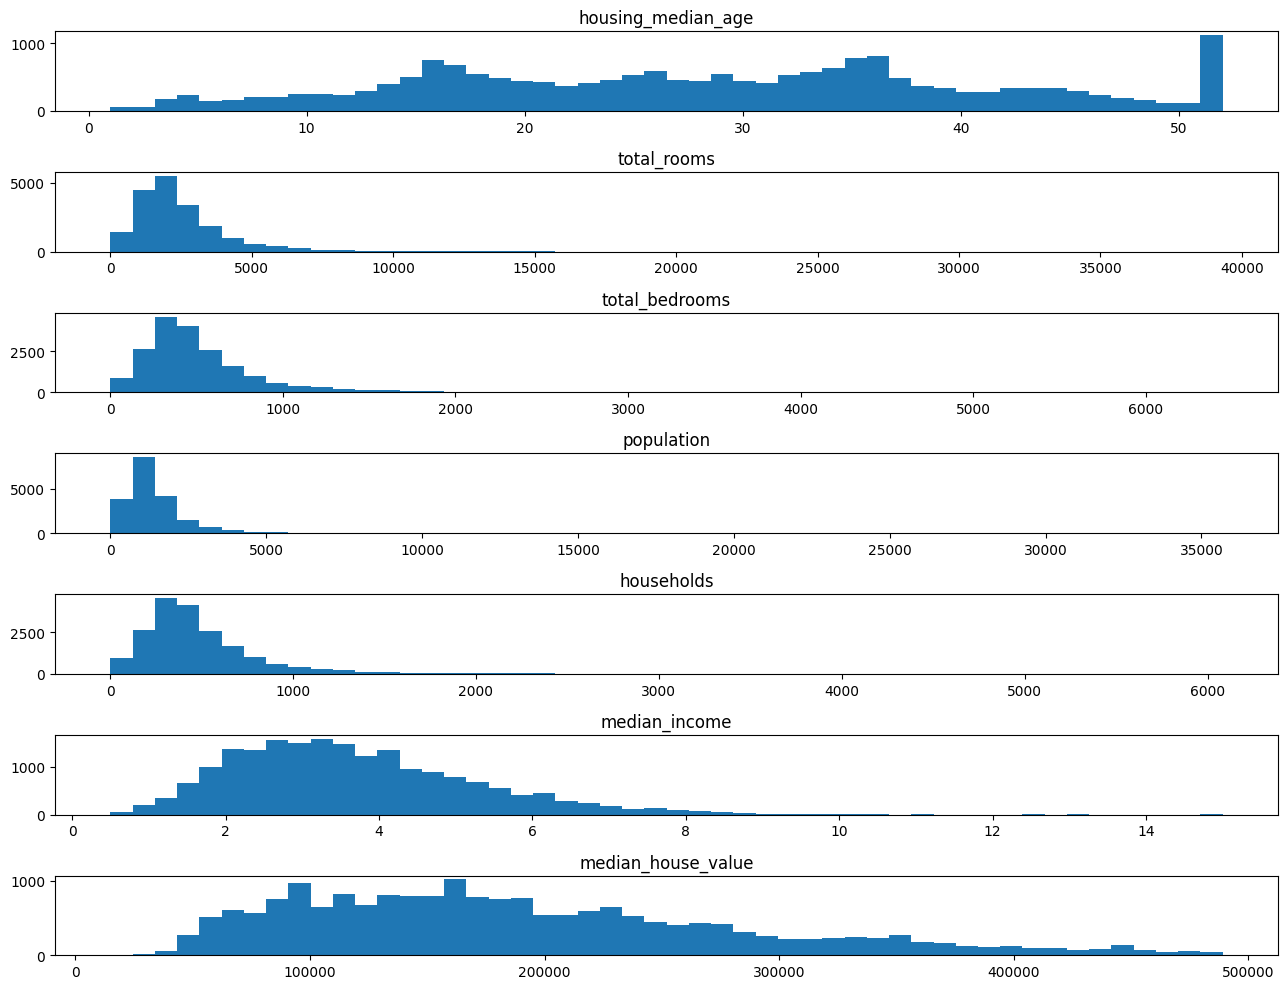

In [14]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, figsize=(13, 10))
ax1.hist(X['housing_median_age'], bins=50)
ax1.set_title('housing_median_age')
ax2.hist(X['total_rooms'], bins=50)
ax2.set_title('total_rooms')
ax3.hist(X['total_bedrooms'], bins=50)
ax3.set_title('total_bedrooms')
ax4.hist(X['population'], bins=50)
ax4.set_title('population')
ax5.hist(X['households'], bins=50)
ax5.set_title('households')
ax6.hist(X['median_income'], bins=50)
ax6.set_title('median_income')
ax7.hist(Y, bins=50)
ax7.set_title('median_house_value')
plt.tight_layout()
plt.show()

2. Use `pandas.dataframe.describe()` function to find the mean, median and standard deviations for each feature and report in the jupyter notebook.

In [15]:
X.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,19557.000000,19557.000000,19557.000000,19557.000000,19557.000000,19557.000000,19557.000000,19557.000000
mean,-119.555893,35.653914,28.382932,2616.732219,538.904229,1439.350463,500.437235,3.674338
std,2.006460,2.145166,12.477333,2177.881801,420.926549,1140.941522,381.780796,1.574519
min,-124.350000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.760000,33.930000,18.000000,1445.000000,298.000000,801.000000,283.000000,2.518700
50%,-118.490000,34.280000,29.000000,2123.000000,435.000000,1173.000000,409.000000,3.447200
75%,-117.980000,37.730000,37.000000,3110.000000,646.000000,1738.000000,603.000000,4.590000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100


3. Use `pandas.get_dummies` to convert categorical variables into dummy /one-hot encoding. In this case the categorical column is ocean_proximity 

In [16]:
X = pd.get_dummies(X, columns=['ocean_proximity'], drop_first=True)
X.describe()
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
1,-122.23,37.88,45,2127,435.0,1166,409,0.8000,False,False,True,False
5,-117.65,35.00,29,2127,435.0,1166,409,2.0000,True,False,False,False
6,-117.65,35.00,29,2127,435.0,1166,409,6.0000,True,False,False,False
7,-117.65,35.00,29,2127,435.0,1166,409,7.0000,True,False,False,False
8,-122.23,37.88,41,880,129.0,322,126,8.3252,False,False,True,False


In [17]:
Y.head()

1    450000
5    100000
6     50000
7     99000
8    452600
Name: median_house_value, dtype: int64

#### iii. Data Splitting

1. Split data into training and test sets using the sklearn `train_test_split()` function. Perform 70-30 distribution i.e. 70% training and 30% testing. The result of your data split should yield 4 separate data frames `X_train, X_test, y_train, y_test`. (respectively, the training features, testing features, training targets and testing target).

In [18]:
print(X.shape)
print(Y.shape)

(19557, 12)
(19557,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [20]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(13689, 12)
(13689,)
(5868, 12)
(5868,)


#### iv. Data Scaling

1. Use the `StandardScaler()` to instantiate the standard scaler class. Note: You will need two separate scaler objects, one to scale the features, another to scale the target values. 

In [21]:
sc_features = StandardScaler()
sc_target = StandardScaler()

2. For each scaler, employ the `fit_transform()` function (only on the training  features, training targets) of the scaler to retrieve the new (scaled) version of the data. Store them in `X_train`, and `y_train` again

In [22]:
print(X_train.head())
print(y_train.head())

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12382    -116.36     33.78                   6        24121          4522.0   
2409     -119.12     36.69                  13         3963           812.0   
4851     -118.29     34.03                  27         1084           287.0   
7504     -118.25     33.93                  27          581           135.0   
13315    -117.62     34.08                  24         2801           554.0   

       population  households  median_income  ocean_proximity_INLAND  \
12382        4176        2221         3.3799                    True   
2409         1905         671         2.2278                    True   
4851         1085         279         2.1350                   False   
7504          647         131         3.2917                   False   
13315        2064         529         4.4946                    True   

       ocean_proximity_ISLAND  ocean_proximity_NEAR BAY  \
12382                   False    

In [23]:
X_train = sc_features.fit_transform(X_train)
y_train = sc_target.fit_transform(y_train.values.reshape(-1, 1))

3. Scale the `X_test` and `y_test` as well and store the scaled values back in `X_test` and `y_test`. (i.e., use the appropriate “fitted” scaler above to “transform” the test data. Note: the function to be employed in this case is `transform()` as opposed to `fit_transform()`).  
Henceforth, `X_train, y_train, X_test, y_test` will refer to the scaled data unless stated otherwise.

In [24]:
X_test = sc_features.transform(X_test)
y_test = sc_target.transform(y_test.values.reshape(-1, 1))

4. Use `pandas.DataFrame.hist(bins = 50)` function for visualizing the variation of numerical attributes housing_median_age, total_rooms, total_bedrooms, population, household, median_income and median_house_value for the `X_train` and `y_train` dataset (similar to step b.ii.1 above). Once again, plot each histogram as a separate subplot. 

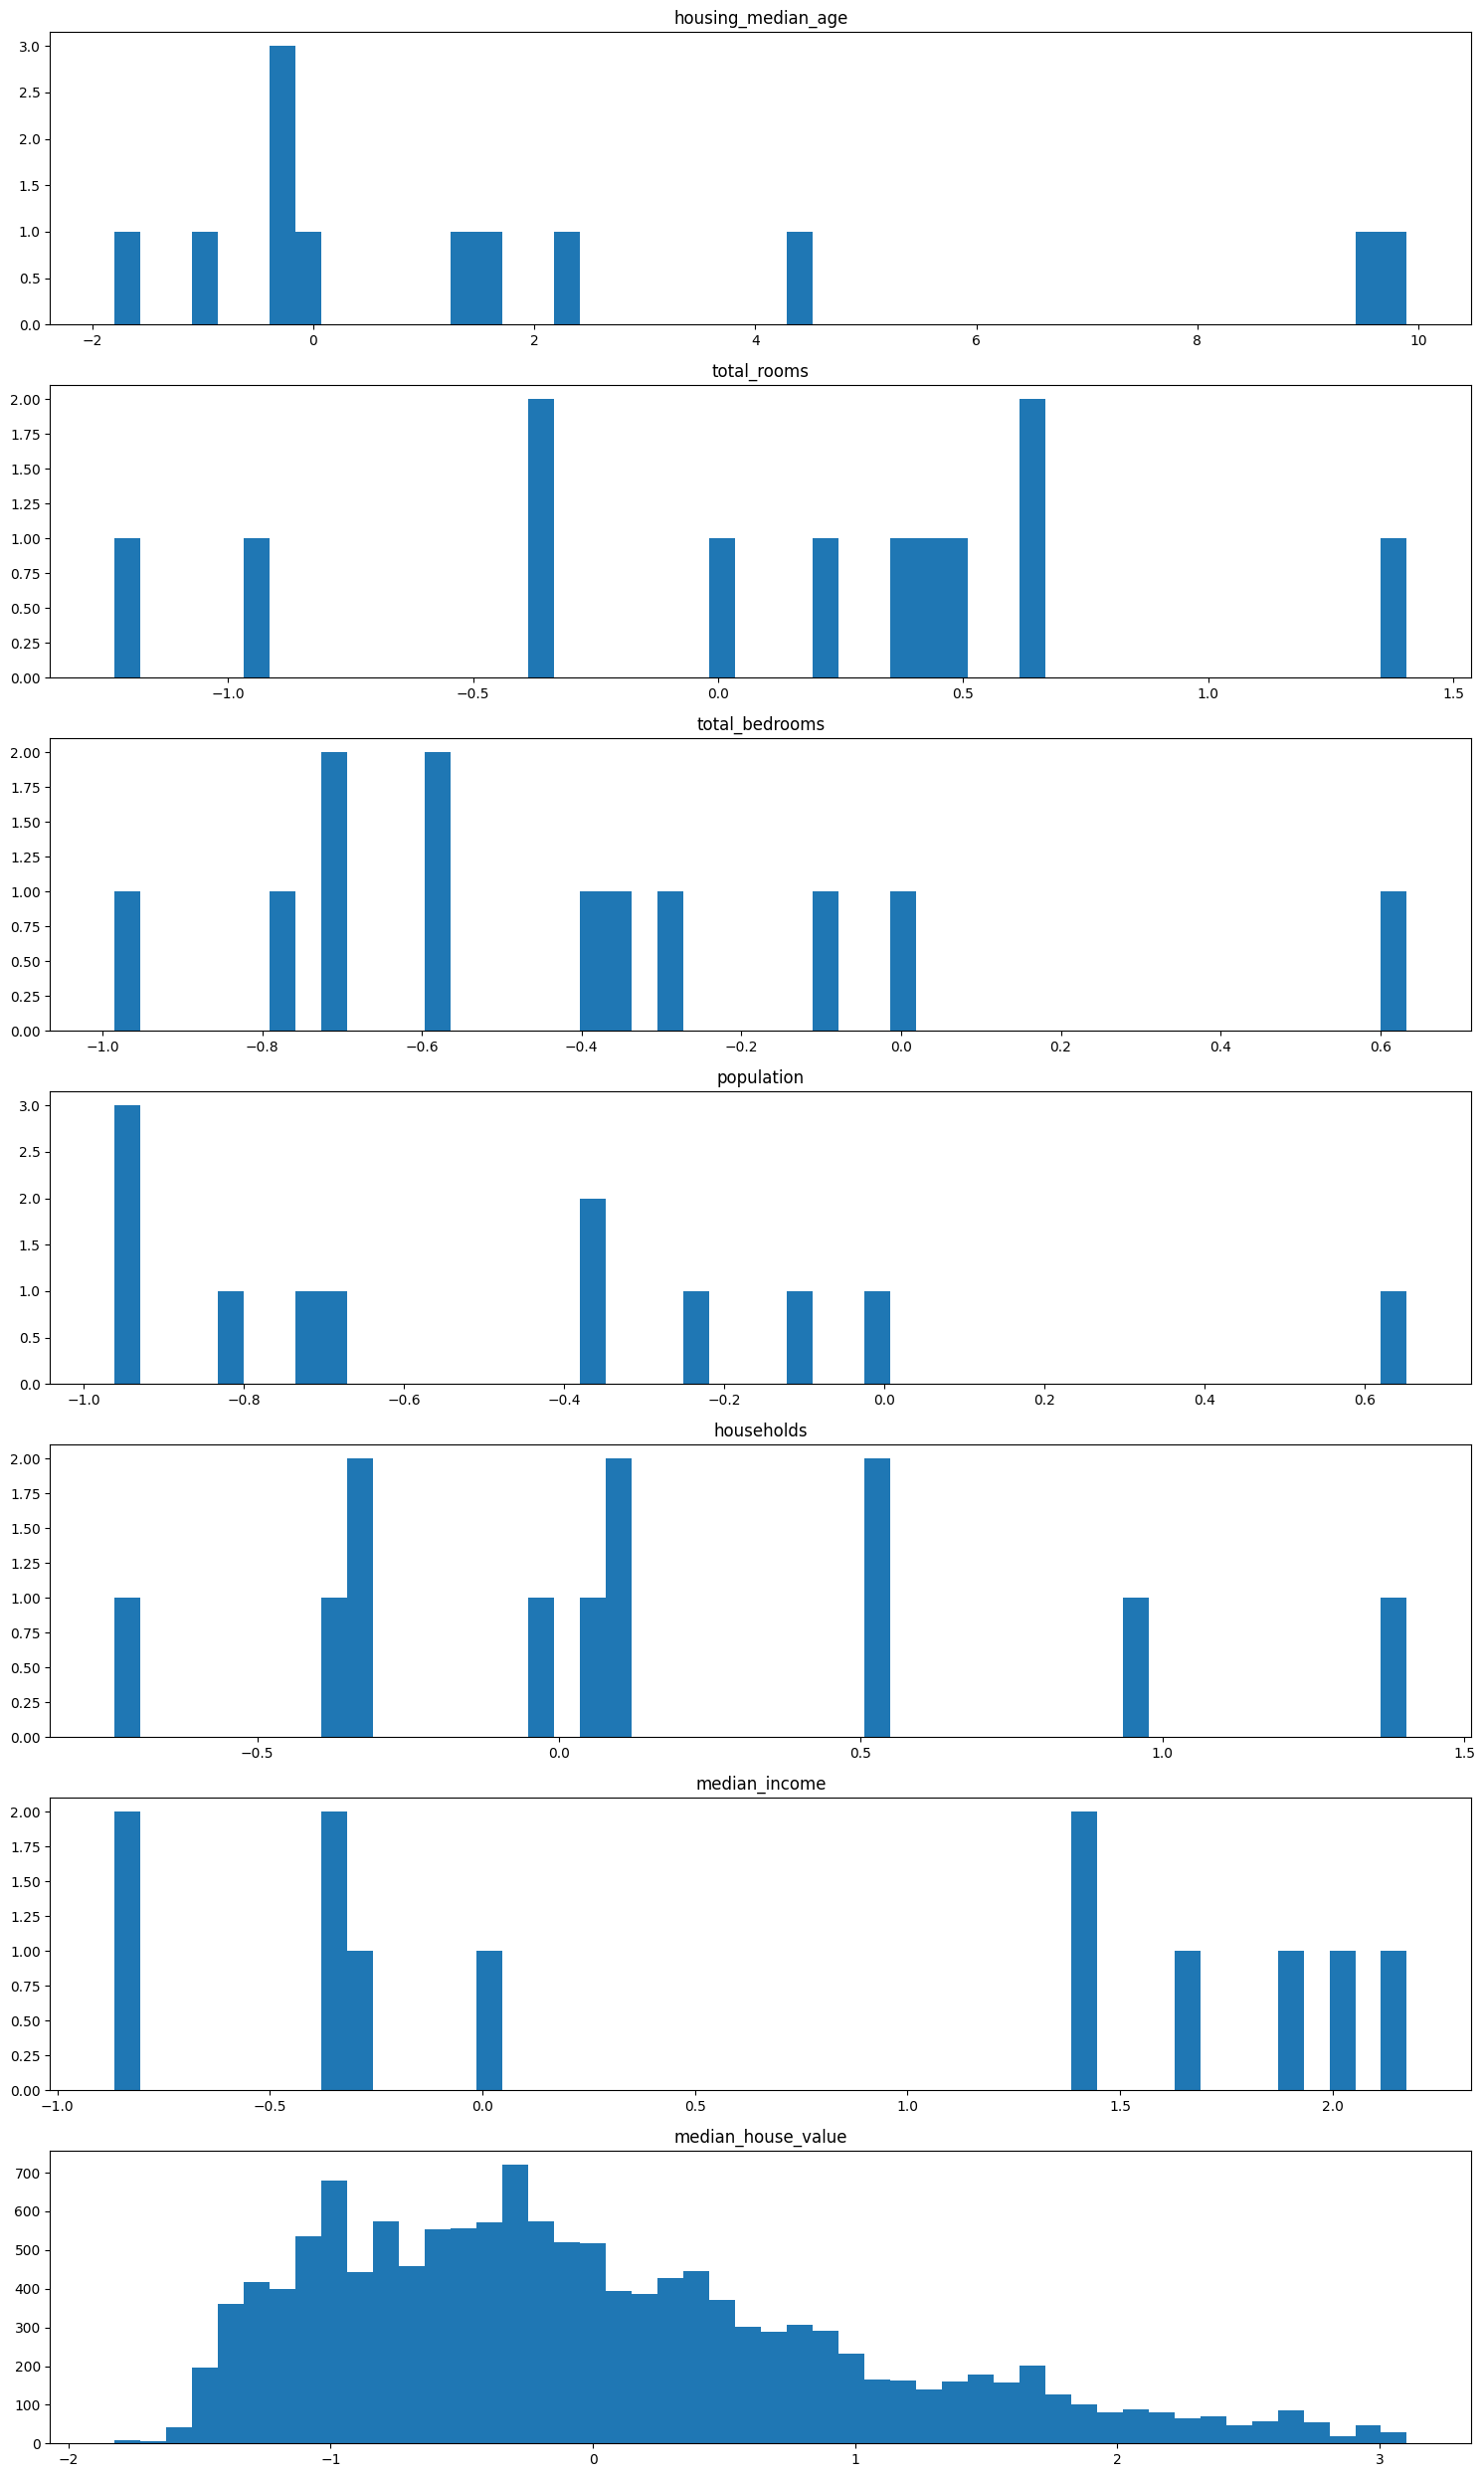

In [25]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, figsize=(15, 25))
ax1.hist(X_train[0], bins=50)
ax1.set_title('housing_median_age')
ax2.hist(X_train[1], bins=50)
ax2.set_title('total_rooms')
ax3.hist(X_train[2], bins=50)
ax3.set_title('total_bedrooms')
ax4.hist(X_train[3], bins=50)
ax4.set_title('population')
ax5.hist(X_train[4], bins=50)
ax5.set_title('households')
ax6.hist(X_train[5], bins=50)
ax6.set_title('median_income')
ax7.hist(y_train, bins=50)
ax7.set_title('median_house_value')
plt.tight_layout()
plt.show()

### c. Modelling

#### i. Employ Linear Regression from sklearn.linear_model, and instantiate the model.

In [26]:
linear_model = LinearRegression()

#### ii. Once instantiated, `fit()` the model using the scaled `X_train, y_train` data.

In [27]:
linear_model.fit(X_train, y_train)

LinearRegression()

#### iii. Employ the `predict()` function to obtain predictions on `X_test`. Store the predictions in a variable named `y_preds`. Note: Since the model has been trained on scaled data (i.e., both features and targets, the predictions will also be in the “scaled” space. We need to transform the predictions back to the original space). 

In [28]:
y_preds = linear_model.predict(X_test)

In [29]:
y_preds

array([[-0.90387045],
       [-0.04898844],
       [-0.14627539],
       ...,
       [ 0.19013613],
       [ 0.02509649],
       [-0.24325525]])

#### iv. Use `inverse_transform()` function to convert the normalized data (`y_preds` ) to original scale. Store the transformed values back into `y_preds`.

In [30]:
y_preds = sc_target.inverse_transform(y_preds)

In [31]:
y_preds

array([[103421.6070185 ],
       [185629.56196563],
       [176274.16397093],
       ...,
       [208624.48053977],
       [192753.78543045],
       [166948.29698021]])

#### v. Perform PCA on the features (`X_train`) and set `n_components` as 2.

In [32]:
pca = PCA(n_components=2)
pca.fit(X_train)

PCA(n_components=2)

1. Show a scatter plot where on the x-axis we plot the first PCA component and second component on the y-axis.

/Users/jrizzo/Projects/courses/CS556/.devenv/state/venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.isfinite(val)


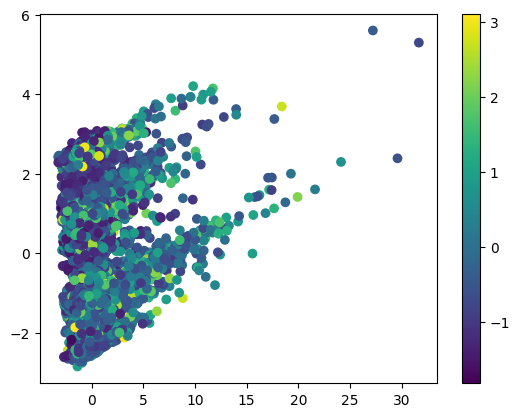

In [33]:
# plt.scatter(pca.transform(X_train)[:, 0], pca.transform(X_train)[:, 1], c=y_train, cmap='viridis')
xtrans = pca.transform(X_train)
plt.scatter(xtrans[:, 0], xtrans[:, 1], c=y_train)
plt.colorbar()
plt.show()

2. Calculate the total percentage of variance captured by the 2 PCA components using `pca.explained_variance_ratio_`. Also, report the strength of each PCA component using `pca.singular_values_`.

In [34]:
print(f'Total % Variance Captured: {100*sum(pca.explained_variance_ratio_)}')
print(f'Strength of Principal Components: {pca.singular_values_}')

Total % Variance Captured: 51.40604986451128
Strength of Principal Components: [231.88430142 175.13811905]


Features ranked by importance:
              Feature  Importance
0           longitude    0.819479
1            latitude    0.764797
7       median_income    0.483271
5          population    0.338945
4      total_bedrooms    0.210746
6          households    0.142078
2  housing_median_age    0.109366
3         total_rooms    0.026813


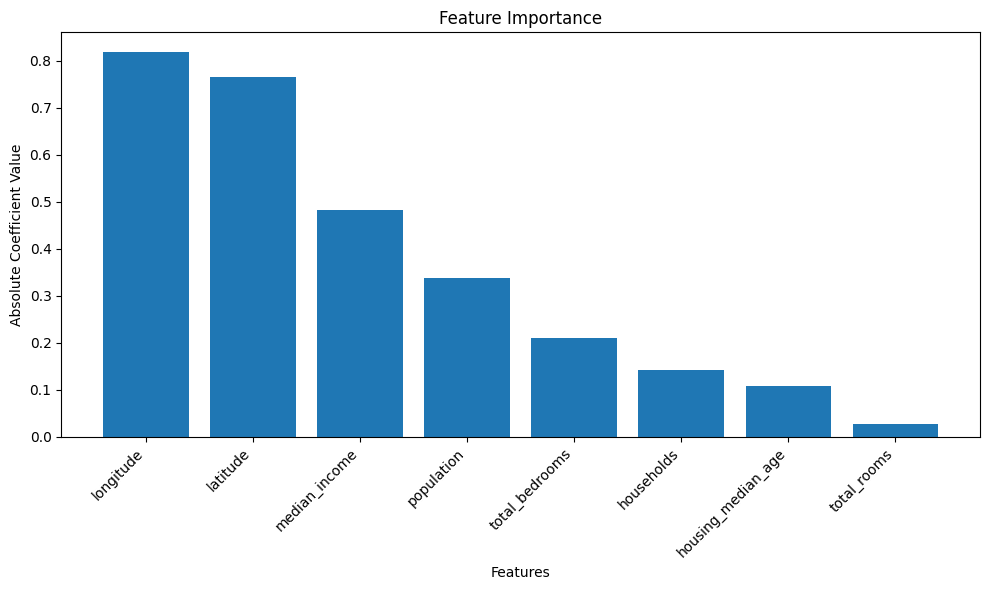

In [42]:
# Get feature importances based on the magnitude of coefficients
feature_names = list(X.columns if isinstance(X, pd.DataFrame) else range(X.shape[1]))
coefficients = linear_model.coef_[0]
importance = np.abs(coefficients)

# Create a DataFrame of features and their importances
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Print continuous features in decreasing order of influence
print("Features ranked by importance:")
print(feature_importance)

# Create a bar chart visualization
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xticks(rotation=45, ha='right')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

### d. Evaluation

#### i. Plot a scatter plot using matplotlib.pyplot.scatter function. Plot the predicted median house values on the y-axis vs the actual median house values on the x-axis

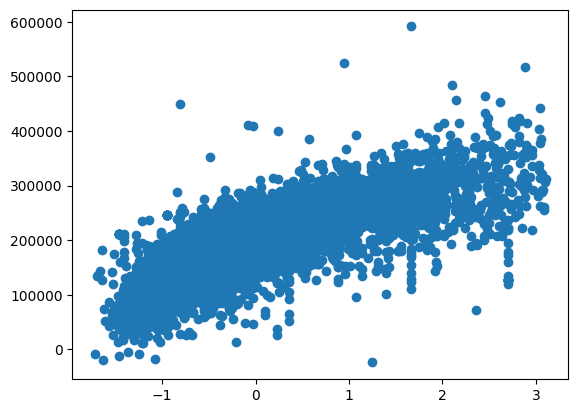

In [35]:
plt.scatter(y_test, y_preds)
plt.show()

#### ii. Calculate MAPE, RMSE and R2 for the model and report them in the following table.

In [36]:
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_preds)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_preds)}')
print(f'R2: {r2_score(y_test, y_preds)}')

MAPE: 1471174.9088584748
RMSE: 205557.92032339892
R2: -40634939656.74232


#### iii. To check how the model performs without removing the outliers, read the dataframe again, and remove the missing values, scale it and retrain the model using sklearn and report the MAPE,RMSE and $\text{R}^2$ in the format specified in evaluation #2

In [37]:
df = pd.read_csv('housingmod.csv')
df = df.dropna()
X = df.drop('median_house_value', axis=1)
Y = df['median_house_value']
X_dummies = pd.get_dummies(X['ocean_proximity'])
X = X.drop('ocean_proximity', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
sc_features = StandardScaler()
sc_target = StandardScaler()
X_train = sc_features.fit_transform(X_train)
y_train = sc_target.fit_transform(y_train.values.reshape(-1, 1))
X_test = sc_features.transform(X_test)
y_test = sc_target.transform(y_test.values.reshape(-1, 1))
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_preds = linear_model.predict(X_test)
y_preds = sc_target.inverse_transform(y_preds)
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_preds)}')
print(f'RMSE: {root_mean_squared_error(y_test, y_preds)}')
print(f'R2: {r2_score(y_test, y_preds)}')

MAPE: 1803264.708641179
RMSE: 228929.2141310129
R2: -50837818649.29756


## Finally, make sure to answer all the discussion questions in your solution document.